In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [42]:
import gymnasium as gym

In [43]:
import cv2

In [44]:
def obs2cell(obs, downsampled_height=11, downsampled_width=8, downsampled_depth=8):
  cell = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
  cell = cv2.resize(cell, (downsampled_height, downsampled_width), interpolation = cv2.INTER_AREA)
  cell = cell // (255 / downsampled_depth)
  return cell

In [45]:
env = gym.make('ALE/MontezumaRevenge-v5', frameskip=4, repeat_action_probability=0.95)

In [46]:
obs, info = env.reset()
obs, _, term, trunc, info = env.step(1)

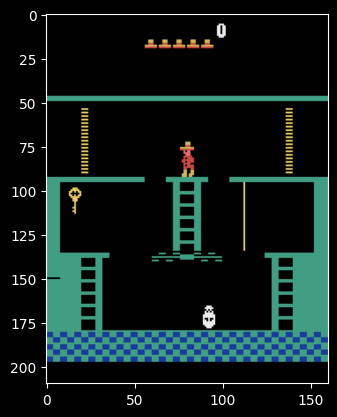

In [47]:
plt.imshow(obs)

In [48]:
info

{'lives': 6, 'episode_frame_number': 4, 'frame_number': 4}

In [102]:
from IPython.display import clear_output


100.0 1438


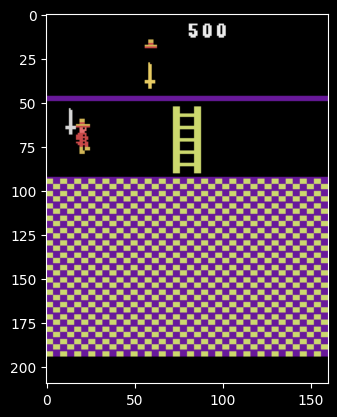

KeyboardInterrupt: 

In [103]:
import gymnasium as gym
import cv2
import numpy as np
from hashlib import sha256
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("dark_background")

class Archive(OrderedDict):
  def __init__(self):
    self = OrderedDict()

  def add(self, reference, score, terminal, info, trajectory, ram, cell, is_root):
    height, width = cell.shape
    self[reference] = {'score': score,
                       'terminal': terminal,
                       'info': info,
                       'trajectory': trajectory,
                       'ram': ram,
                       'height': height,
                       'width': width,
                       'times chosen': 0,
                       'times chosen since new cell found': 0,
                       'times seen': 1}

    if not is_root:
      root_reference = trajectory.get('references')[0]
      self[root_reference]['times chosen since new cell found'] = 0

  def visited(self, reference):
    self[reference]['times seen'] += 1

  def returned(self, reference):
    self[reference]['times chosen'] += 1
    self[reference]['times chosen since new cell found'] += 1

def batch_reset():
  states = []
  for env in envs:
    state, _ = env.reset()
    states.append(state)
  return states

def batch_step(actions, repeat, render=False):
  global frame
  states, rewards, terminals, infos = [], [], [], []
  for action, env in zip(actions, envs):
    for i in range(repeat):
      # if frame % frameskip == 0: envs[0].render()
      state, reward, terminal, _, info = env.step(action)
      if reward > 0:
          clear_output()
          print(reward, len(archive))
          plt.imshow(state)
          plt.show()
      if env_name == "MontezumaRevenge-v0": terminal = terminal or info['lives'] < 6
    states.append(state)
    rewards.append(reward)
    terminals.append(terminal)
    infos.append(info)
    frame += 1
    if render and frame % frameskip == 0:
      batch_render(states)
  return states, rewards, terminals, infos

def get_factor_pairs(number):
  return [(factor, number // factor) for factor in range(1, int(number ** 0.5) + 1) if number % factor == 0]

def get_optimal_display_configuration(number):
  pairs = get_factor_pairs(number)
  diff = [abs(height - width) for width, height in pairs]
  height, width = pairs[np.argmin(diff)]
  return height, width

def batch_render(states):
  for state, window_title in zip(states, window_titles):
    cv2.imshow(window_title, cv2.cvtColor(state, cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)

def make_cell(state, downsampled_height, downsampled_width, downsampled_depth):
  cell = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
  cell = cv2.resize(cell, (downsampled_height, downsampled_width), interpolation = cv2.INTER_AREA)
  cell = cell // (255 / downsampled_depth)
  return cell

def make_reference(cell):
  cell_as_string = ''.join(cell.astype(int).astype(str).flatten())
  cell_as_bytes = cell_as_string.encode()
  cell_as_hash_bytes = sha256(cell_as_bytes)
  cell_as_hash_hex = cell_as_hash_bytes.hexdigest()
  cell_as_hash_int = int(cell_as_hash_hex, 16)
  cell_as_hash_string = str(cell_as_hash_int)
  return cell_as_hash_string

def CntScore(idx, times_chosen, times_chosen_since_new, times_seen):
  score1 = times_chosen_weight * ((1 / (times_chosen[idx] + e1)) ** times_chosen_power) + e2
  score2 = times_chosen_since_new_weight * ((1 / (times_chosen_since_new[idx] + e1)) ** times_chosen_since_new_power) + e2
  score3 = times_seen_weight * ((1 / (times_seen[idx] + e1)) ** times_seen_power) + e2
  return score1 + score2 + score3 + 1

# Cell parameters
downsampled_height, downsampled_width = (11, 8)
downsampled_depth = 8

# Exploration parameters
sticky_actions_repeat = 4

# Hyperparameters
decay = 0.999

# Return parameters
e1 = 0.001
e2 = 0.00001
times_chosen_weight = 0.1
times_chosen_since_new_weight = 0
times_seen_weight = 0.3
times_chosen_power = 1
times_chosen_since_new_power = 1
times_seen_power = 1

# Batch exploration parameters
# num_actors = int(input("Enter number of simultaneous simulations (If you are rendering each one, make it a number with two similar factors. 8 is good; a low perfect square like 16 is ideal: "))
num_actors = 8

# Environment parameters
# env_name = input("Enter Environment Name ID (ie. MontezumaRevenge-v0 or Pitfall-v0): ")
env_name = 'ALE/MontezumaRevenge-v5'
envs = [gym.make(env_name) for i in range(num_actors)]
observation_height, observation_width, _ = envs[0].observation_space.shape

# Rendering parameters
frameskip = 50
render = False

# Time parameters
episodes = 0
frame = 0

# Metrics parameters
cells_found = []

if render:
  height, width = get_optimal_display_configuration(num_actors)
  window_ids, window_titles = [], []
  for y in range(height):
    for x in range(width):
      window_id = (y * width) + x
      window_title = "Actor %s" % (window_id + 1)
      cv2.namedWindow(window_title)
      cv2.moveWindow(window_title, x * observation_width, y * observation_height)
      window_ids.append(window_id)
      window_titles.append(window_title)

# Archive information
archive = Archive()

# Trajectory constant
empty_trajectory = {'actions': [], 'references': []}

# Initial exploration state setup
states = batch_reset()
initial_cell = make_cell(states[0], downsampled_height, downsampled_width, downsampled_depth)
initial_reference = make_reference(initial_cell)
score = 0
references = [initial_reference] * num_actors
archive.add(initial_reference, score, False, None, empty_trajectory, envs[0].env.clone_state(include_rng=True), initial_cell, True)
all_refs = [initial_reference]

trajectories = [empty_trajectory for i in range(num_actors)]
scores = [archive[reference]['score'] for reference in references]

while True:
  actions = [env.action_space.sample() for env in envs]
  states, rewards, terminals, infos = batch_step(actions, sticky_actions_repeat, render = render)
  scores = [score + reward for score, reward in zip(scores, rewards)]
  cells = [make_cell(state, downsampled_height, downsampled_width, downsampled_depth) for state in states]
  references = [make_reference(cell) for cell in cells]
  rams = [env.env.clone_state(include_rng=True) for env in envs]
  discounts = [decay ** len(trajectory.get('actions')) for trajectory in trajectories]

  for i, (action, reference) in enumerate(zip(actions, references)):
    trajectories[i]['actions'].append(action)
    trajectories[i]['references'].append(reference)

  if all([len(trajectory.get('actions')) > 0 for trajectory in trajectories]):
    for reference, score, terminal, info, trajectory, ram, cell in zip(references, scores, terminals, infos, trajectories, rams, cells):
      if reference in archive:
        archive.visited(reference)
        if len(trajectory.get('actions')) < len(archive.get(reference).get('trajectory').get('actions')):
          archive[reference]['trajectory'] = trajectory
      else:
        archive.add(reference, score, terminal, info, trajectory, ram, cell, False)
        all_refs.append(reference)

  discounts = [discount * decay for discount in discounts]

  if any(terminals):
    times_chosen = [archive.get(reference).get('times chosen') for reference in archive]
    times_chosen_since_new = [archive.get(reference).get('times chosen since new cell found') for reference in archive]
    times_seen = [archive.get(reference).get('times seen') for reference in archive]
    cell_scores = np.array([CntScore(i, times_chosen, times_chosen_since_new, times_seen) for i in range(len(archive))])
    total_score = sum(cell_scores)
    cell_probs = cell_scores / total_score

    for i, terminal in enumerate(terminals):
      if terminal:
        return_idx = np.random.choice(np.arange(len(all_refs)), p = cell_probs)
        ref = all_refs[return_idx]
        archive.returned(ref)
        envs[i].reset()
        envs[i].env.restore_state(archive.get(ref).get('ram'))
        trajectories[i] = archive.get(ref).get('trajectory')
        scores[i] = archive.get(ref).get('score')

        episodes += 1
        cells_found.append(len(archive))

    # if episodes > 1:
    #   fig = plt.figure(figsize = (3, 3))
    #   plt.plot(cells_found)
    #   plt.xlim(0, episodes - 1)
    #   plt.ylim(0,)
    #   plt.xlabel("Episode")
    #   plt.ylabel("Cells")
    #   plt.close()
    #   filename = "%s_exploration.jpeg" % env_name
    #   fig.savefig(filename)
    #   cv2.imshow("Exploration", cv2.imread(filename))
    #   cv2.waitKey(1)

In [99]:
len(archive)

340

In [90]:
vs = [v for k, v in archive.items()]

In [60]:
for k, v in archive.items():
    pass

In [63]:
v.keys()

dict_keys(['score', 'terminal', 'info', 'trajectory', 'ram', 'height', 'width', 'times chosen', 'times chosen since new cell found', 'times seen'])

In [67]:
v['info']

{'lives': 1, 'episode_frame_number': 12944, 'frame_number': 12944}

In [79]:
v['ram']

In [73]:
len(v['trajectory']['actions'])

50864